In [147]:
import os
import sys
import pickle
import warnings 
import string

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import ticker
from scipy import stats
from sklearn.cluster import AgglomerativeClustering   
from AnalyseDefects_dev import AnalyseDefects

from utils import gen_clustering_metadata, extract_clustering_results,\
      do_poisson_clustering_improved, two_sample_test

plt.style.use('sg_article')

In [148]:
def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 1, LX = LL, Nframes = 400)
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = 2, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 3, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list





In [149]:
LX = 2048
output_path = f'data\\nematic_analysis{LX}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict(LX, mode)
ad = AnalyseDefects(defect_list, output_path=output_path)


base_path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na{LX}'
out_path = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\na{LX}cl'
Nframes_l = 400 if LX < 2048 else 180
Nframes_vl = 1500 if LX < 2048 else 400


d_cluster_l = dict(path = base_path + 'l_cl', \
            suffix = "l_cl", priority = 1, LX = LX, Nframes = Nframes_l)
d_cluster_vl = dict(path = base_path + 'vl_cl', \
            suffix = "vl_cl", priority = 1, LX = LX, Nframes = Nframes_vl)
    
    
Nexp_l, act_l, act_dir_l = gen_clustering_metadata(d_cluster_l['path'])
Nexp_vl, act_vl, act_dir_vl = gen_clustering_metadata(d_cluster_vl['path'])

frame_idx_cutoff = Nframes_vl
Ncmin = 3
min_act_idx_l = 1 if LX == 512 else 0
lidx_long = -2

# Poission clustering arguments
Rmax = 33
Nsim_data_ratio = 5 #1 if LX == 1024 else 5
Ntrial = Nsim_data_ratio * frame_idx_cutoff * len(Nexp_vl)
use_grid = True

method_kwargs = dict(n_clusters=None, linkage = 'single', distance_threshold=Rmax)


Analyze single-linkage agglomerative clustering results for defect data
 

In [150]:
load = True
save = True
Nframes_l = d_cluster_l['Nframes']
Nframes_vl = d_cluster_vl['Nframes']

if load:
    cl_arr_l = np.load(os.path.join(f'{out_path}','l_cl\\cluster_arr.npy'))
    cl_arr_vl = np.load(os.path.join(f'{out_path}', 'vl_cl\\cluster_arr.npy'))
    cl_mean_l = np.load(os.path.join(f'{out_path}','l_cl\\cl_mean.npy'))
    cl_mean_vl = np.load(os.path.join(f'{out_path}', 'vl_cl\\cl_mean.npy'))
    cl_std_l = np.load(os.path.join(f'{out_path}', 'l_cl\\cl_std.npy'))
    cl_std_vl = np.load(os.path.join(f'{out_path}', 'vl_cl\\cl_std.npy'))
else:
    cl_arr_l, cl_mean_l, cl_std_l = extract_clustering_results(d_cluster_l, Nframes_l, 
                                    ad.conv_list[lidx_long], act_l, \
                                                    act_dir_l, len(Nexp_l), Ncmin=Ncmin, save=save)
    cl_arr_vl, cl_mean_vl, cl_std_vl = extract_clustering_results(d_cluster_vl, Nframes_vl,
                                     ad.conv_list[-1], act_vl, act_dir_vl, Nexp=len(Nexp_vl), Ncmin=Ncmin, save=save)

cl_arr_vl_orig = cl_arr_vl.astype(np.float64)
cl_arr_l_orig = cl_arr_l.astype(np.float64)

if frame_idx_cutoff > Nframes_l:
    cl_arr_l = np.nan * np.ones((frame_idx_cutoff, *cl_arr_l.shape[1:]))
    cl_arr_l[:Nframes_l] = cl_arr_l_orig

cl_arr_vl = cl_arr_vl[-frame_idx_cutoff:]
Nframes_vl = frame_idx_cutoff

for i, act in enumerate(act_l):
    first_frame_idx = ad.conv_list[lidx_long][list(ad.act_list[lidx_long]).index(act)]
    cl_arr_l[:first_frame_idx, :, i, :] = np.nan
for i, act in enumerate(act_vl):
    if act in ad.act_list[-1]:
        Ndataset = -1 
    else:
        Ndataset = lidx_long
    first_frame_idx = ad.conv_list[Ndataset][list(ad.act_list[Ndataset]).index(act)]
  #  print(first_frame_idx)
    cl_arr_vl[:first_frame_idx, :, i, :] = np.nan

exp_cutoff_idx = 5 if LX == 2048 else None

def_arr = np.concatenate([cl_arr_vl[-frame_idx_cutoff:, 0, :, :], cl_arr_l[:, 0, min_act_idx_l:, :exp_cutoff_idx]], axis=1)
def_arr_reshaped = def_arr.transpose(0,2,1).reshape(def_arr.shape[0] * def_arr.shape[-1], def_arr.shape[1])

cl_mean = np.concatenate([cl_mean_vl, cl_mean_l[:,min_act_idx_l:]], axis=1)
cl_std = np.concatenate([cl_std_vl, cl_std_l[:,min_act_idx_l:]], axis=1)

act_list = np.unique(np.concatenate([act_vl, act_l[min_act_idx_l:]]))

Below, Poisson simulation is done whilst allowing Ndef to vary for each activity, and also allowing for doing a greater number of Poisson simulation that we have defects frames.

Below, Poisson simulation is done whilst allowing Ndef to vary for each activity, and also allowing for doing a greater number of Poisson simulation that we have defects frames.

In [151]:
load_uni = False
save_uni = True
Ntrial = 5 * Nframes_vl * len(Nexp_vl)
save_path = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\na{LX}cl\\uni_conv'

def_arr = np.concatenate([cl_arr_vl[-frame_idx_cutoff:, 0, :, :], cl_arr_l[:, 0, min_act_idx_l:, :exp_cutoff_idx]], axis=1)
def_arr_reshaped = def_arr.transpose(0,2,1).reshape(def_arr.shape[0] * def_arr.shape[-1], def_arr.shape[1])

if load_uni:
    cl_arr_uni = np.load(os.path.join(f'{out_path}','uni\\cluster_arr_uni.npy'))
    cl_mean_uni = np.load(os.path.join(f'{out_path}','uni\\cl_mean_uni.npy'))
    cl_std_uni = np.load(os.path.join(f'{out_path}','uni\\cl_std_uni.npy'))
else:
    cl_arr_uni , cl_mean_uni, cl_std_uni = do_poisson_clustering_improved(def_arr_reshaped, LX, Ntrial=Ntrial, use_grid = use_grid,\
                                                                       Ncmin = Ncmin, method_kwargs = method_kwargs,save=save_uni)

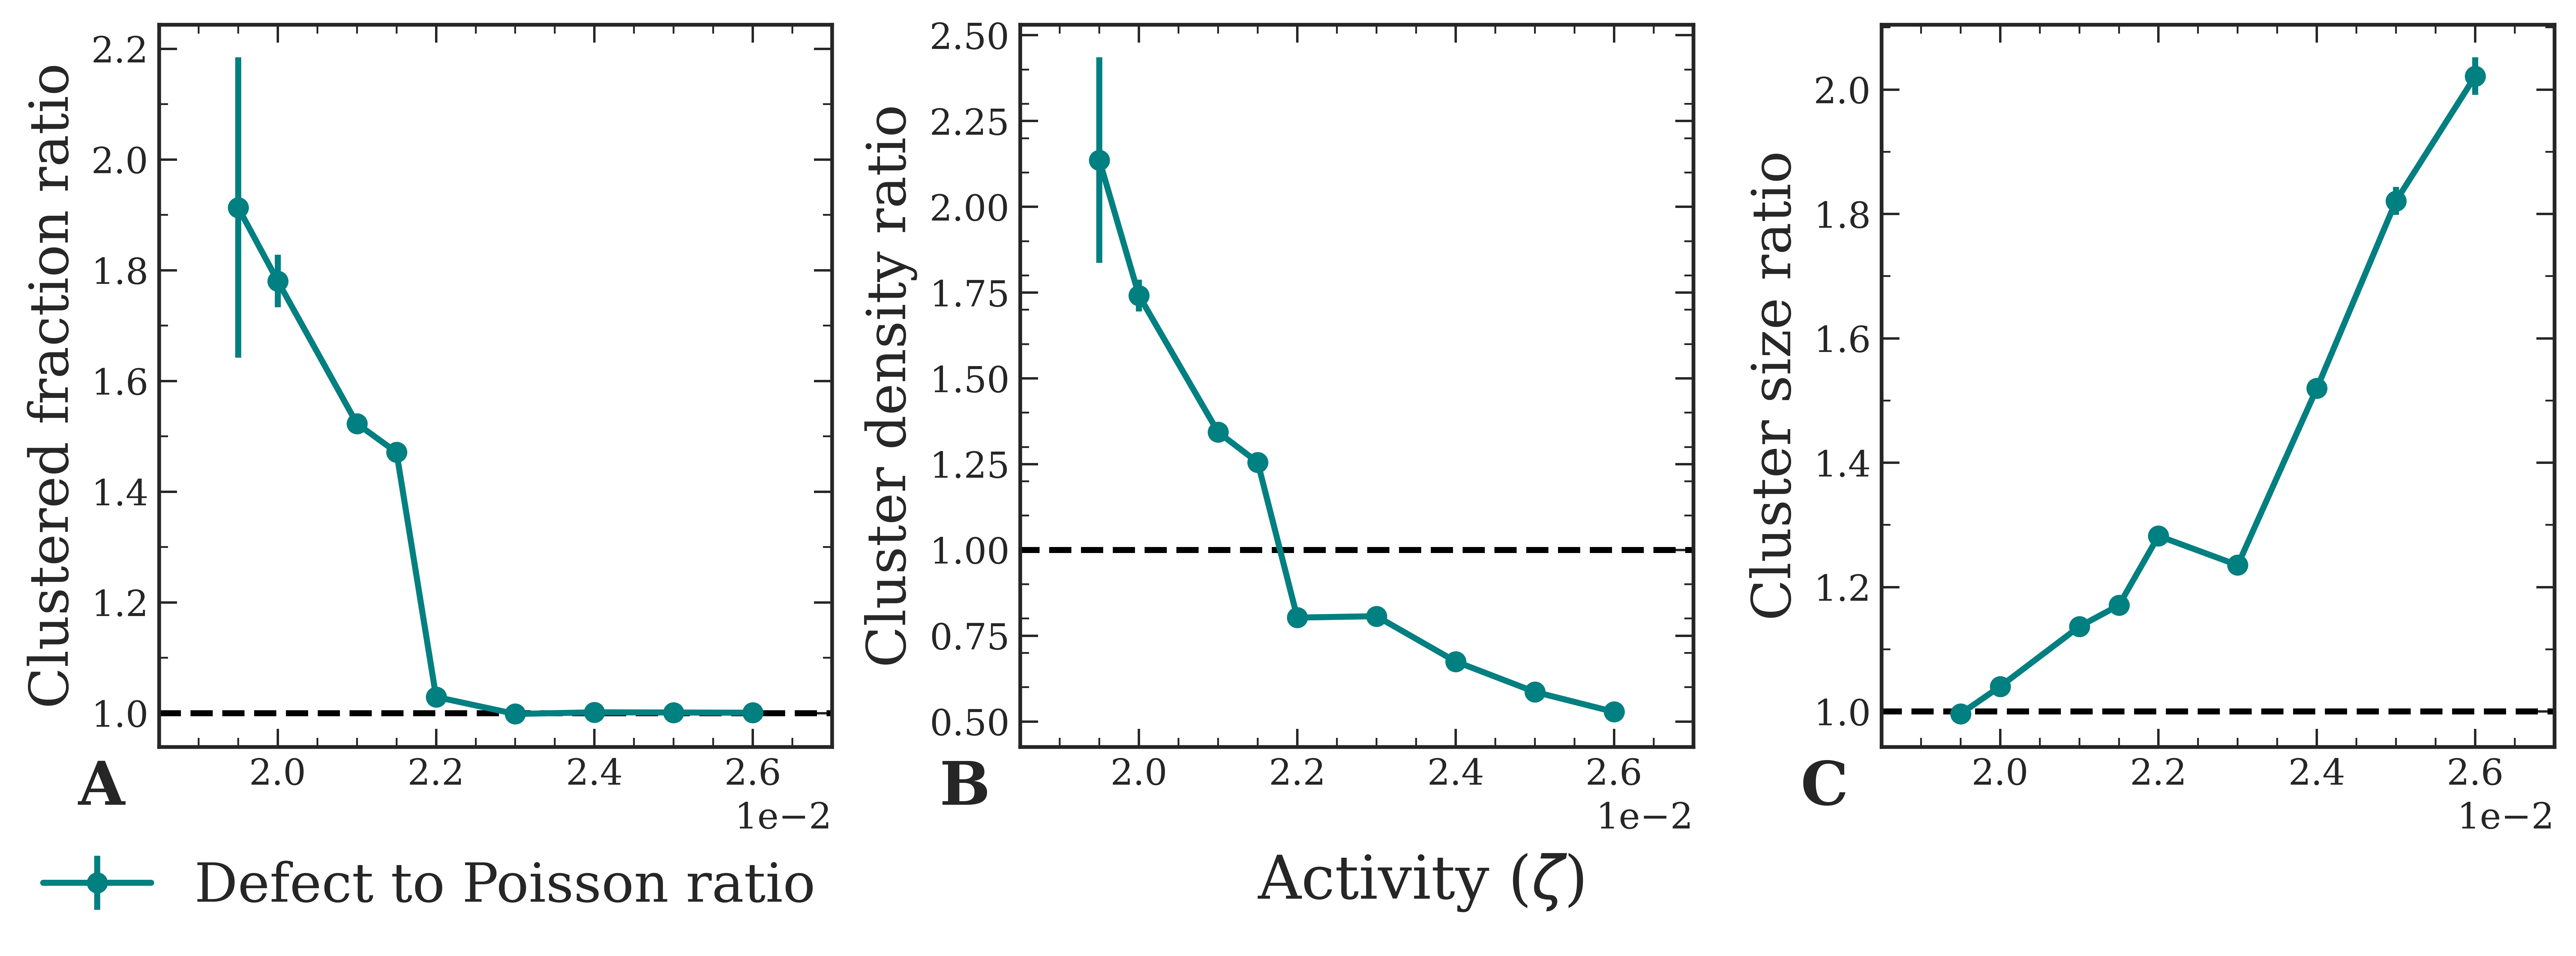

In [152]:
fig, ax = plt.subplots(ncols = 3, figsize = (12, 4.5)) 
ax = ax.flatten()
min_act_idx = 1

X = act_list[min_act_idx:]
Y = cl_mean[1:4, min_act_idx:].astype(np.float64)
dY = cl_std[1:4, min_act_idx:].astype(np.float64)

Y_uni = cl_mean_uni[1:4, min_act_idx:]
dY_uni = cl_std_uni[1:4, min_act_idx:]

Ydif = Y - Y_uni
Ydif_err = np.sqrt(dY**2 + dY_uni**2)
res_arr = Ydif / Ydif_err

Yfrac = Y / Y_uni
Yfrac_err = np.sqrt((dY / Y_uni)**2 + (Y * dY_uni / Y_uni**2)**2)
ylabel_list = ['Clustered fraction ratio', 'Cluster density ratio', 'Cluster size ratio']

#for i in range(3):

 #   ax[i].errorbar(X, Yfrac[i], Yfrac_err[i], fmt='o-', label=ylabel_list[i])
  #  ax[i].set_ylabel(f'{ylabel_list[i]}')   

# save Yfrac and Yfrac_err
np.save(os.path.join(out_path, 'Yfrac.npy'), Yfrac)
np.save(os.path.join(out_path, 'Yfrac_err.npy'), Yfrac_err)
np.save(os.path.join(out_path, 'act_list.npy'), X)

y_min_tick_dist = [0.02, 1, 10]        
for n, axx in enumerate(ax):
    axx.hlines(1, 0, 1, linestyle='--', color='black')
    label = 'Defect to Poisson ratio' if n == 0 else None
    axx.errorbar(X, Yfrac[n], Yfrac_err[n], fmt='o-', label=label)
    axx.set_ylabel(f'{ylabel_list[n]}')   
    axx.set_xlim(X[0] - 0.001, X[-1] + 0.001)
    axx.text(-0.12, -.08, string.ascii_uppercase[n], transform=axx.transAxes,
            size=20, weight='bold')
   # xticks = [2e-2, 2.2e-2, 2.4e-2]
   # axx.set(xticks=xticks,xticklabels=xticks)
    axx.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    axx.xaxis.set_minor_locator(ticker.MultipleLocator(0.0005))
   # ax[n].yaxis.set_minor_locator(ticker.MultipleLocator(y_min_tick_dist[n]))
fig.legend(loc = 'lower left', ncol=1,bbox_to_anchor=(0.0, 0.0), fontsize = 18)
#fig.supylabel(t='Residuals (units of SEM)', x=1.01, y=0.55, fontsize=20)
fig.supxlabel(t = f'Activity ($\zeta$)', y=0.05, x=0.55, fontsize=20)
fig.tight_layout()

fig.dpi = 720
if not os.path.isdir(os.path.join(out_path, 'figs')):
    os.makedirs(os.path.join(out_path, 'figs'))
fig_savepath = os.path.join(out_path, f'figs\\cl_ratio.png')
fig.savefig(fig_savepath, dpi = 720, pad_inches = .1, bbox_inches = 'tight')

In [ ]:
#cl_frac = cl_arr_vl[:,1,:,:] / cl_arr_vl[:,0,:,:]
#cl_frac_uni = cl_arr_uni[1, :, :] / cl_arr_uni[0, :, :]
act = 0.0205
act_idx = act_vl.index(act) if act < 0.0225 else act_l.index(act)
act_idx_uni = list(act_list).index(act)

Ndataset = -1 if act < 0.0225 else -2
first_frame_idx = ad.conv_list[Ndataset][list(ad.act_list[Ndataset]).index(act)]


fig, ax = plt.subplots(ncols=3, figsize=(12,4.5))
ax = ax.flatten()
title_list = ['Fraction of points in cluster', 'No. of clusters', 'Average cluster size']
if LX == 512:
    range_list = [(0, 1), (0, 150), (2, 20)]
if LX == 1024:
    range_list = [(0.4, 1), (20, 100), (3,16)]
if LX == 2048:
    range_list = [(0.6, .8), (150, 350), (4,10)]
nbins_list = [80, range_list[1][1] - range_list[1][0], 80]
nbins = 100
for i, axx in enumerate(ax):

   # data = cl_arr_vl[:, i + 1, :, :]
    norm = LX ** 2 if i == 5 else 1

    data = cl_arr_vl_orig[first_frame_idx:, i + 1, :, :] / norm if act < 0.0225 else cl_arr_l_orig[first_frame_idx:, i + 1, :, :] / norm
    data_uni = cl_arr_uni[i + 1, :, :] / norm
  
    ## Examine combatibility with Kolmogrov test under the null hypothesis that the cumulative distribution of data_uni if shifted
    # towards larger values than data (so that Cum(data(x)) <= Cum(data_uni(x))). Alt. hypothesis: Cum(data(x)) > Cum(data_uni(x))
    _, p_val = stats.ks_2samp(data[:, act_idx, :].flatten(), data_uni[act_idx_uni, :].flatten(), alternative = 'two-sided')

    print('\np-value that cum_dist of data is shifted towards higher values than data_uni: ', p_val)


    # Use t-test to calculate p_value under the null hypothesis that the 2 means are equal, letting the alternative hypothesis be that the mean of the drug group
    # is greater than that of the control group
    #t_val, p_val = stats.ttest_ind(data[:, act_idx, :].flatten(), data_uni[act_idx_uni, :].flatten(), equal_var = False, alternative = 'greater')
    #print("t_val and pval that the two means are ID (alt: mean of data is greater) (using a one-tailed 2 sample t-test)", t_val, p_val)

    x_legend = 0.05 if i < 2 else 0.6
    y_legend = 0.85
    if p_val < 1e-9:
        pval_to_print = 'p < 1e-9'
    elif p_val > 0.99:
        pval_to_print = f'p = {p_val:.4f}'
    else:
        pval_to_print = f'p = {p_val:.2e}'

    axx.text(x_legend, y_legend, rf'{pval_to_print}', fontsize=16, transform=axx.transAxes)

    density = True
    
    label = 'Defects' if i == 0 else None
    label_uni = 'Poisson' if i == 0 else None   

    axx.hist(data[:, act_idx, :].flatten(), lw=2, range = range_list[i], bins=nbins_list[i], \
            histtype='stepfilled', alpha=.7, label = label, density=density)
    axx.hist(data_uni[act_idx_uni, :].flatten(), lw=2, range = range_list[i], bins=nbins_list[i], \
            histtype='step', alpha=1, label = label_uni, density=density, color='coral')#, edgecolor='orange')

    #axx.vlines(np.mean(data[:, act_idx, :]), 0, 0.2, color='teal', linestyle='-', lw=2)
    #axx.vlines(np.mean(data_uni[act_idx_uni, :]), 0, .2, color='coral', linestyle='-', lw=2)
    print('Mean of data: ', np.nanmean(data[:, act_idx, :]), '+/', np.nanstd(data[:, act_idx, :], ddof=1) / np.sqrt(Nframes_vl * len(Nexp_vl)))
    print('Mean of data_uni: ', np.nanmean(data_uni[act_idx_uni, :]), '+/', np.nanstd(data_uni[act_idx_uni, :], ddof=1) / np.sqrt(Ntrial)  )

    axx.set_xlabel(xlabel = title_list[i])
    #axx.legend()
xtick_list = [0.05,5,1]
ytick_list = [0.5, 0.5, 0.05]
ytick_list[1] = 0.005 if LX == 2048 else 0.5
xtick_list[-1] = 0.5 if LX == 2048 else 1
for n, axx in enumerate(ax):
    x_pos = -.15 if n == 0 else -.05
    ax[n].text(x_pos, -.13, string.ascii_uppercase[n], transform=ax[n].transAxes,
            size=20, weight='bold')
    ax[n].xaxis.set_minor_locator(ticker.MultipleLocator(xtick_list[n]))
    ax[n].yaxis.set_minor_locator(ticker.MultipleLocator(ytick_list[n]))
   # ax[n].yaxis.set_minor_locator(ticker.MultipleLocator(y_min_tick_dist[n]))

fig.legend(ncol=2, bbox_to_anchor=(0.705, 1.09), fontsize=18)
fig.supylabel(t = 'Density', x=0.02);
#fig.suptitle(t = rf'Clustering results for $\zeta$ = {act} (L = {L})');
fig_savepath = os.path.join(out_path, f'figs\\cl_hist.png')
fig.savefig(fig_savepath, dpi = 720, pad_inches = .1, bbox_inches = 'tight')

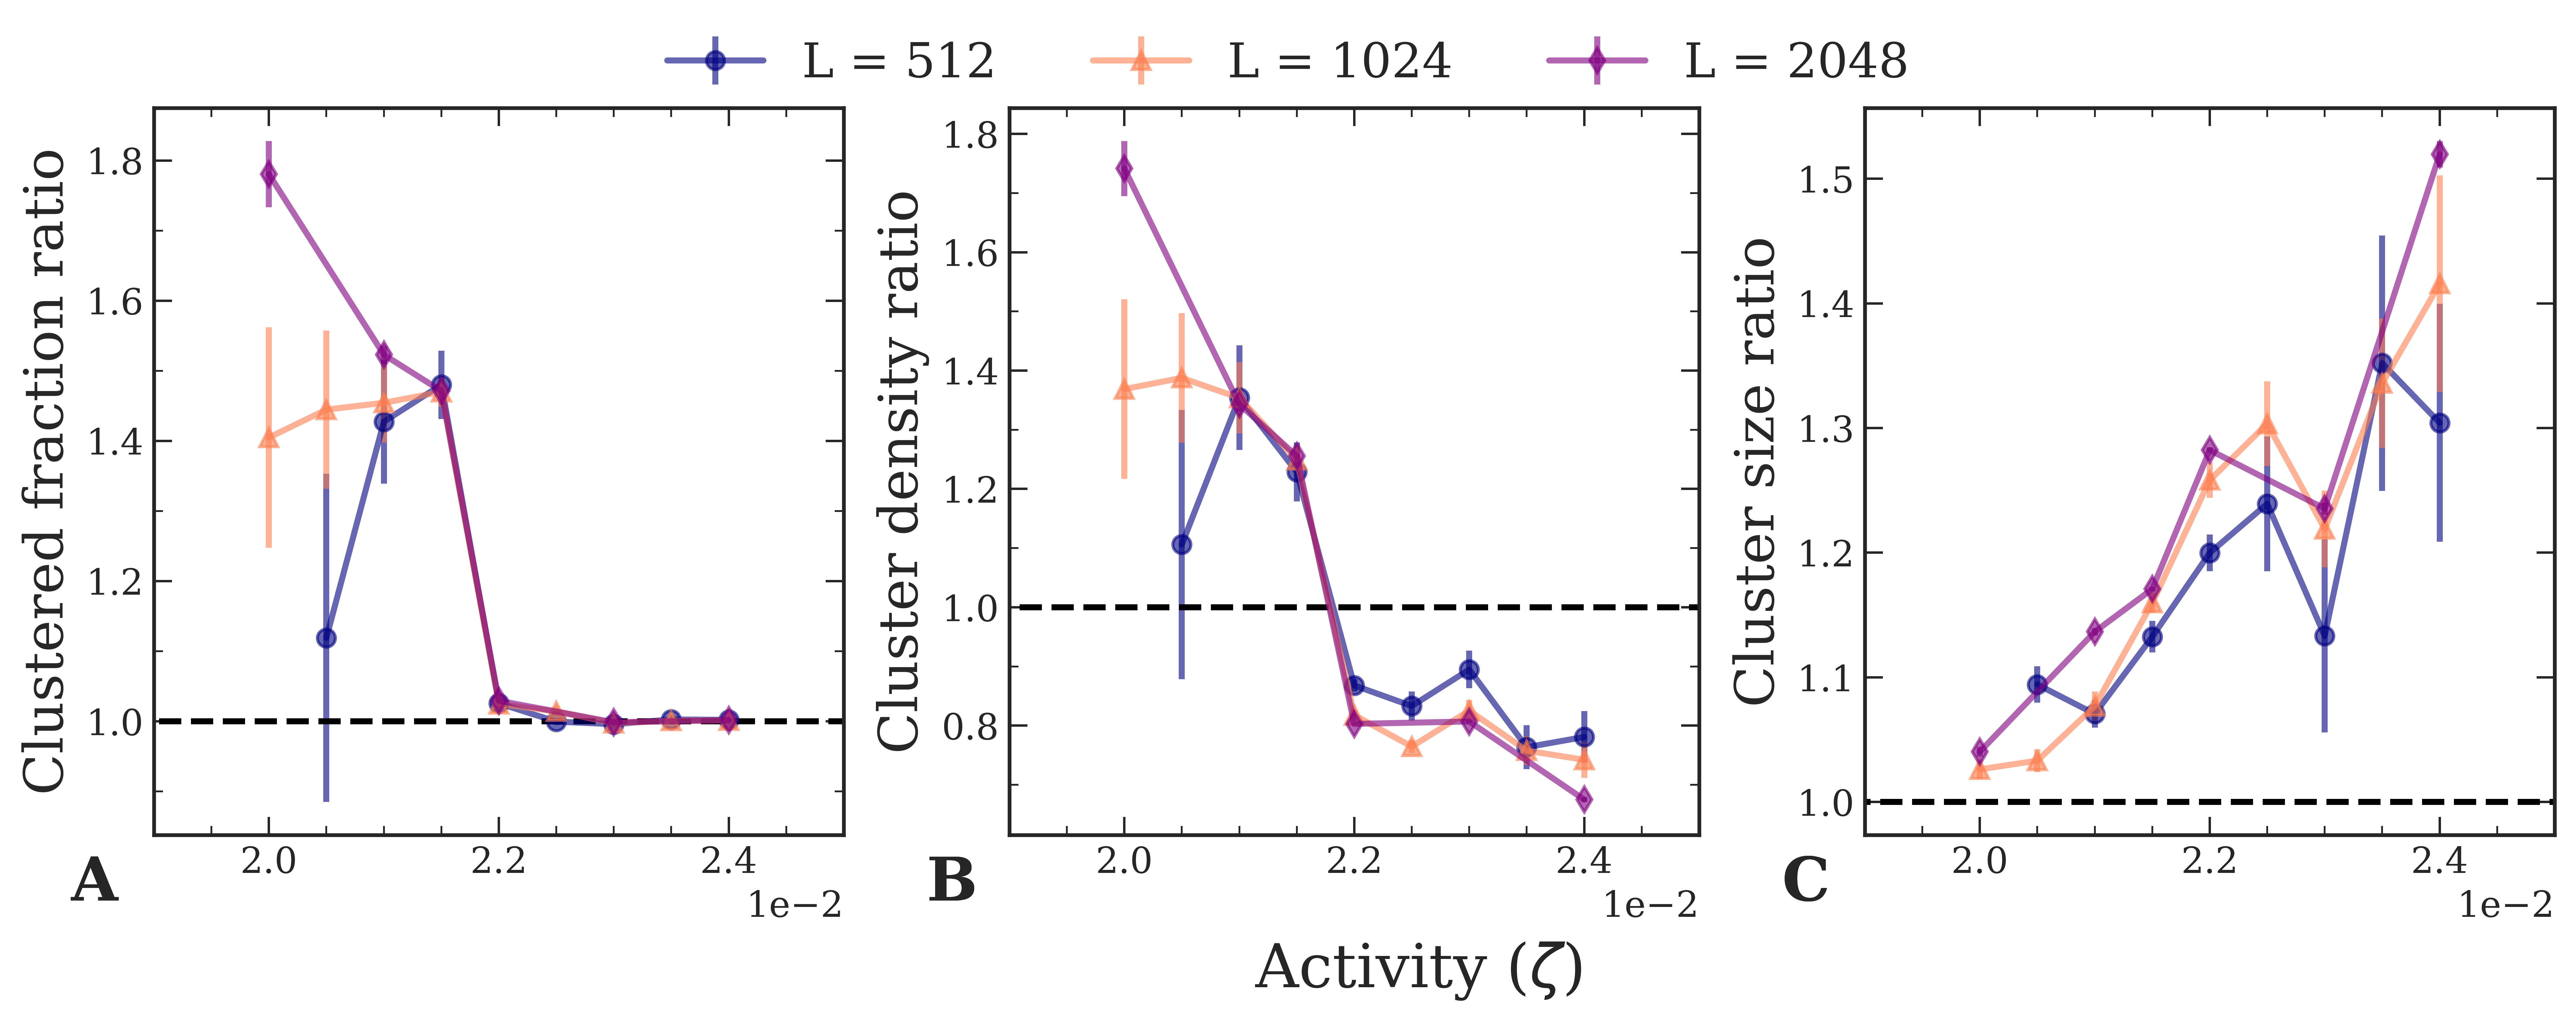

In [153]:
L_list = [512, 1024, 2048]
marker = ['o','^','d']
act_idx_bounds = [(1, None), (1, None), (1, -2)]

fig, ax = plt.subplots(ncols=3, figsize=(12,4.5))
ax = ax.flatten()

for i, LX in enumerate(L_list):
    out_path = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\na{LX}cl'
    Yfrac = np.load(os.path.join(out_path, 'Yfrac.npy'))[:,act_idx_bounds[i][0]:act_idx_bounds[i][1]]
    Yfrac_err = np.load(os.path.join(out_path, 'Yfrac_err.npy'))[:,act_idx_bounds[i][0]:act_idx_bounds[i][1]]
    X = np.load(os.path.join(out_path, 'act_list.npy'))[act_idx_bounds[i][0]:act_idx_bounds[i][1]]

    y_min_tick_dist = [0.02, 1, 10]        
    for n, axx in enumerate(ax):
        axx.hlines(1, 0, 1, linestyle='--', color='black')
        label = f'L = {LX}' if n == 0 else None
        axx.errorbar(X, Yfrac[n], Yfrac_err[n], 
                    marker=f'{marker[i]}', label=label,
                    color=f'C{i+1}', alpha = .6) 
        axx.set_ylabel(f'{ylabel_list[n]}')   
        axx.set_xlim(X[0] - 0.001, X[-1] + 0.001)
        axx.text(-0.12, -.09, string.ascii_uppercase[n], transform=axx.transAxes,
                size=20, weight='bold')
    # xticks = [2e-2, 2.2e-2, 2.4e-2]
    # axx.set(xticks=xticks,xticklabels=xticks)
        axx.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
        axx.xaxis.set_minor_locator(ticker.MultipleLocator(0.0005))
    # ax[n].yaxis.set_minor_locator(ticker.MultipleLocator(y_min_tick_dist[n]))
    #fig.legend(ncol=3,bbox_to_anchor=(0.5, 1), fontsize = 18)
fig.legend(loc='upper center', ncol=8, fontsize = 16, bbox_to_anchor=(0.5, 1.08))
#fig.supylabel(t='Residuals (units of SEM)', x=1.01, y=0.55, fontsize=20)
fig.supxlabel(t = f'Activity ($\zeta$)', y=0.05, x=0.55, fontsize=20)
fig.tight_layout()

fig.dpi = 720;
   # if not os.path.isdir(os.path.join(out_path, 'figs')):
   #     os.makedirs(os.path.join(out_path, 'figs'))
   # fig_savepath = os.path.join(out_path, f'figs\\cl_ratio.png')
   # fig.savefig(fig_savepath, dpi = 720, pad_inches = .1, bbox_inches = 'tight')


In [114]:
av_defects=ad.get_arrays_av(-1)[-1]
defect_arr = ad.get_arrays_full(-1)[0]
conv_list = ad.conv_list[-1]
act_list = ad.act_list[-1]

for i, act in enumerate(act_list):
    first_frame_idx = conv_list[i]
    print(np.nanmean(defect_arr[first_frame_idx:, i, :],axis=(0,-1)))
    print(av_defects[i,0])

4.4896
4.4896
9.553166666666666
9.553166666666666
13.9592
13.9592
21.107866666666666
21.107866666666666
36.778666666666666
36.778666666666666
148.5518
148.5518


In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (12, 6)) 

min_act_idx = 1

X = act_list[min_act_idx:]
Y = cl_mean[1:4, min_act_idx:].astype(np.float64)
dY = cl_std[1:4, min_act_idx:].astype(np.float64)

# take care of altered errors due to truncation
#for i, act in enumerate(act_list[min_act_idx:]):
 #   if act in act_vl:
  #      dY[:, i] *= np.sqrt(1500) / np.sqrt(Nframes_vl)

Y_uni = cl_mean_uni[1:4, min_act_idx:]
dY_uni = cl_std_uni[1:4, min_act_idx:]

Ydif = Y - Y_uni
Ydif_err = np.sqrt(dY**2 + dY_uni**2)
res_arr = Ydif / Ydif_err

for i in range(3):

    if i == 0:
        ax[i].set_ylim(0, 1)    
        kwargs_dict = dict(label = 'Top. defects')
        kwargs_dict_uni = dict(label = 'Poisson')
    else:
        kwargs_dict = dict()
        kwargs_dict_uni = dict()


    ax[i].errorbar(X, Y[i], yerr=dY[i], fmt='-o', color = 'green', **kwargs_dict)
    ax[i].errorbar(X, Y_uni[i], yerr=dY_uni[i], fmt='^-', color = 'blue', **kwargs_dict_uni, alpha=0.7)


    ax[i].set_ylabel(['Clustered fraction','Nclusters', 'Av. cluster size'][i])
    # set activity limits
    axinn_xlims = [1.98e-2, 2.42e-2]
    axinn_xticks = np.linspace(axinn_xlims[0]+2e-4, axinn_xlims[1] - 2e-4,5)
    ax[i].set(xticks=axinn_xticks, xlim=axinn_xlims)
    
    axx0 = ax[i].twinx()
    res_norm = res_arr[i]
    res_max = np.nanmax(np.abs(res_norm))


    if i == 0:
        bottom = -.33
        res_zero = -.25
        bottom_shift = res_zero - bottom
        top = 0
        shift = np.abs(top + res_zero)
        show_std_lines_for = 3

        ax[i].set_ylim(bottom, 1)
        ax[i].set(yticks=np.linspace(0,1,6), yticklabels=np.round(np.linspace(0,1, 6),1))
        
        # normalize res_norm by biggest value
        res_norm_unit = shift * res_norm / np.nanmax(np.abs(res_norm)) + res_zero

        axx0.set_yticks([res_zero - shift * show_std_lines_for/res_max, res_zero + shift * show_std_lines_for/res_max, res_zero + shift/2, top],\
                         [-show_std_lines_for,f' {show_std_lines_for}', int(np.max(res_norm) / 2), int(np.max(res_norm))])
        axx0.set_ylim((bottom, 1))

        axx0.axhline(y=0, color='black', linewidth=1.5)
        axx0.axhline(y=res_zero, color='black', linewidth=1.5)
        axx0.axhline(y=res_zero - shift * show_std_lines_for/res_max, color='grey', lw=.8, linestyle='--')
        axx0.axhline(y=res_zero + shift * show_std_lines_for/res_max, color='grey', lw=.8, linestyle='--')
        axx0.plot(act_list[min_act_idx:], res_norm_unit, 'kx-', label='Residuals')

    if i == 1:
        ax[i].set(yticks=np.linspace(0,15,4), yticklabels=np.linspace(0,15,4).astype('int'))

        res_max_signed = np.nanmax(res_norm)
        res_min_signed = np.nanmin(res_norm) 

        res_range = np.abs(res_max_signed - res_min_signed)
  
        bottom = -6.5
        res_zero = min(np.abs(res_max_signed), np.abs(res_min_signed)) / max(np.abs(res_max_signed), np.abs(res_min_signed)) * bottom
        bottom_shift = res_zero - bottom
        top = 0
        shift = np.abs(top + bottom) 
        show_std_lines_for = 5

        ax[i].set_ylim(bottom, - 3*bottom)

        # normalize res_norm by biggest value
        res_norm_unit = res_norm * (shift / res_range) 
        res_norm_unit -= np.abs(res_max_signed) * (shift / res_range)

        axx0.set_yticks([bottom, res_zero, res_zero + shift * show_std_lines_for/res_max, top],\
                         [f'{int(res_min_signed)}', ' 0',  f'   {show_std_lines_for}', f' {int(res_max_signed)}'],)
        axx0.set_ylim((bottom, -3*bottom))
        axx0.axhline(y=0, color='black', linewidth=1.5)
        axx0.axhline(y=res_zero, color='black', linewidth=1.5)
        axx0.plot(act_list[min_act_idx:], res_norm_unit, 'kx-',) #label='Residuals')
        axx0.axhline(y=res_zero + shift * show_std_lines_for/res_max, color='grey', lw=.8, linestyle='--')


    if i == 2:

        ax[i].set(yticks=np.linspace(0,150,7), yticklabels=np.linspace(0,150,7).astype('int'))

        bottom = -50
        res_zero = bottom
        bottom_shift = res_zero - bottom
        top = 0
        shift = np.abs(top + res_zero) 
        show_std_lines_for = 5

        ax[i].set_ylim(bottom, - 3*bottom)

        # normalize res_norm by biggest value
        res_norm_unit = shift * res_norm / np.nanmax(np.abs(res_norm)) + res_zero

        axx0.set_yticks([res_zero, res_zero + shift/2, top],\
                         [' 0',f'{int(np.max(res_norm) / 2)}', f'{int(np.max(res_norm))}'])
        axx0.set_ylim((bottom, -3*bottom))
        axx0.axhline(y=0, color='black', linewidth=1.5)
        axx0.plot(act_list[min_act_idx:], res_norm_unit, 'kx-',) #label='Residuals')

y_min_tick_dist = [0.02, 1, 10]        
for n, axx in enumerate(ax):
    ax[n].text(-0.12, -.08, string.ascii_uppercase[n], transform=ax[n].transAxes,
            size=20, weight='bold')
   # ax[n].xaxis.set_minor_locator(ticker.MultipleLocator(0.005))
   # ax[n].yaxis.set_minor_locator(ticker.MultipleLocator(y_min_tick_dist[n]))
fig.legend(loc = 'upper right', ncol=3, bbox_to_anchor=(0.84, 1.08), fontsize = 18)
fig.supylabel(t='Residuals (units of SEM)', x=1.01, y=0.55, fontsize=20)
fig.supxlabel(t = f'Activity ($\zeta$)', y=0.05, x=0.55, fontsize=20)
fig.tight_layout()
# set yscale to log
#ax[0].set_yscale('log')

#ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.005))
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1)) 
